In [1]:
import sys
import os
import subprocess

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import re
# import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
# from tqdm import tqdm
import traceback
import hashlib

import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
from event_recognition_efficiency_v3 import *
# import supervised_classification as supc

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Welcome to JupyROOT 6.13/02


In [50]:
# events_data_table_name = 'spb_processing_v3.event'
events_data_table_name = '_old3_spb_processing_v3.event'

In [51]:
data_snippets_dir = 'ver3_data_snippets'
os.makedirs(data_snippets_dir, exist_ok=True)

In [52]:
event_v3_storage_provider = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config.ini'), 
    table_names_version='ver3',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_v4.EventProcessingV3
)

query_functions = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider)

In [53]:
columns_for_analysis_dict = query_functions.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=(
        '^.+$',
    ),
    
    default_excluded_columns_re_list=[],
#     for debugging selection
    included_columns_re_list=[('^$','^source_file_acquisition_full$'), ('^$','^global_gtu$'), ('^$','^packet_id$'), 
                              ('^$','gtu_in_packet'), ('^$','event_id'), ('^$','num_gtu'), 
                              '^bg_x_y*']
)

In [54]:
removed_cols = {'spb_processing_v3.event_bg_x_y':['median','median_gz','size']}
for table,cols_list in columns_for_analysis_dict.items():
    if table not in removed_cols:
        continue
    for removed_col in removed_cols[table]:
        try:
            del cols_list[ cols_list.index(removed_col) ]
        except ValueError:
            pass
    
columns_for_analysis_dict

{'spb_processing_v3.event': ['event_id',
  'source_file_acquisition_full',
  'global_gtu',
  'packet_id',
  'gtu_in_packet',
  'num_gtu'],
 'spb_processing_v3.event_bg_x_y': ['event_id',
  'count_nonzero',
  'sum',
  'norm_sum',
  'min',
  'max',
  'mean',
  'std',
  'mean_gz',
  'std_gz',
  'width',
  'height',
  'area'],
 'spb_processing_v3.event_bg_x_y_clusters': ['event_id',
  'count',
  'sizes_min',
  'sizes_max',
  'sizes_mean',
  'sizes_std',
  'sums_sum',
  'sums_min',
  'sums_max',
  'sums_mean',
  'sums_std',
  'clu_widths_max',
  'clu_heights_max',
  'clu_widths_min',
  'clu_widths_mean',
  'clu_heights_mean',
  'clu_widths_std',
  'clu_heights_std',
  'clu_areas_min',
  'clu_areas_max',
  'clu_areas_mean',
  'clu_areas_std',
  'max_area_clu_width',
  'max_area_clu_height',
  'min_area_clu_width',
  'min_area_clu_height',
  'max_size_clu_width',
  'max_size_clu_height',
  'min_size_clu_width',
  'min_size_clu_height',
  'max_sum_clu_width',
  'max_sum_clu_height',
  'min_sum

In [55]:
#import pprint
split_columns_for_analysis_dict = query_functions.split_to_smaller_dicts(columns_for_analysis_dict,50000)
#print(select_clause_str)
for i,g in enumerate(split_columns_for_analysis_dict):
    tot_items = 0
    for k,vl in g.items():
        tot_items += len(vl)
    print(i,tot_items)
    
    for t, vl in g.items():
        sys.stdout.write(t)
        sys.stdout.write('\n\t- ')
        print('\n\t- '.join(vl))
        print()
    
    print('-'*60)

0 73
spb_processing_v3.event
	- event_id
	- source_file_acquisition_full
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v3.event_bg_x_y
	- event_id
	- count_nonzero
	- sum
	- norm_sum
	- min
	- max
	- mean
	- std
	- mean_gz
	- std_gz
	- width
	- height
	- area

spb_processing_v3.event_bg_x_y_clusters
	- event_id
	- count
	- sizes_min
	- sizes_max
	- sizes_mean
	- sizes_std
	- sums_sum
	- sums_min
	- sums_max
	- sums_mean
	- sums_std
	- clu_widths_max
	- clu_heights_max
	- clu_widths_min
	- clu_widths_mean
	- clu_heights_mean
	- clu_widths_std
	- clu_heights_std
	- clu_areas_min
	- clu_areas_max
	- clu_areas_mean
	- clu_areas_std
	- max_area_clu_width
	- max_area_clu_height
	- min_area_clu_width
	- min_area_clu_height
	- max_size_clu_width
	- max_size_clu_height
	- min_size_clu_width
	- min_size_clu_height
	- max_sum_clu_width
	- max_sum_clu_height
	- min_sum_clu_width
	- min_sum_clu_height
	- max_peak_clu_width
	- max_peak_clu_height
	- min_peak_clu_width
	- min

In [56]:
current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

select_clause_str, joined_tables_list = \
    query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
join_clauses_str = \
    query_functions.get_query_clauses__join(joined_tables_list)
where_clauses_str = ' AND config_info_id=1'
    
events_selection_query = query_functions.get_events_selection_query_plain(
    source_data_type_num=1,
    select_additional=select_clause_str, join_additional=join_clauses_str,
    where_additional=where_clauses_str,
    order_by='{data_table_name}.event_id', limit=350000, offset=0,
    base_select='',
    data_table_name_overwrite=events_data_table_name)

flight_data_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [57]:
flight_data_df

,event_id,source_file_acquisition_full,global_gtu,packet_id,gtu_in_packet,num_gtu,bg_x_y_event_id,bg_x_y_count_nonzero,bg_x_y_sum,bg_x_y_norm_sum,...,bg_x_y_clusters_seed_coords_x_event_id,bg_x_y_clusters_seed_coords_x_mean,bg_x_y_clusters_seed_coords_x_std,bg_x_y_clusters_seed_coords_x_min,bg_x_y_clusters_seed_coords_x_max,bg_x_y_clusters_seed_coords_y_event_id,bg_x_y_clusters_seed_coords_y_mean,bg_x_y_clusters_seed_coords_y_std,bg_x_y_clusters_seed_coords_y_min,bg_x_y_clusters_seed_coords_y_max
0,1,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,168,1,40,10,1.0,1552.0,5717.0,714.625,...,1.0,16.0,0.0,16.0,16.0,1.0,2.0,0.0,2.0,2.0
1,2,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,423,3,39,10,2.0,2249.0,5146.0,735.143,...,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2,3,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,553,4,41,9,3.0,2230.0,4789.0,684.143,...,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
3,4,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,570,4,58,9,4.0,2249.0,5123.0,640.375,...,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
4,5,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,808,6,40,13,5.0,1552.0,5717.0,714.625,...,5.0,16.0,0.0,16.0,16.0,5.0,2.0,0.0,2.0,2.0
5,6,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,825,6,57,13,6.0,2252.0,5168.0,646.000,...,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
6,7,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,129,1,1,128,7.0,2254.0,5302.0,757.429,...,7.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0
7,8,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,257,2,1,128,8.0,2222.0,4856.0,539.556,...,8.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
8,9,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,385,3,1,128,9.0,2251.0,5214.0,651.750,...,9.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
9,10,/home/spbproc/SPBDATA_flight/allpackets-SPBEUS...,513,4,1,128,10.0,1554.0,5907.0,590.700,...,10.0,19.0,0.0,19.0,19.0,10.0,0.0,0.0,0.0,0.0


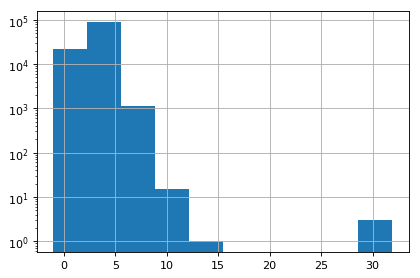

In [58]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_mean_gz.hist()
h.set_yscale('log')
plt.show()

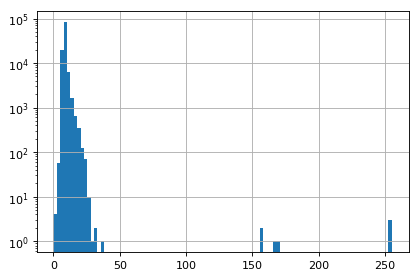

In [60]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_max.hist(bins=100)
h.set_yscale('log')
plt.show()

In [44]:
import seaborn

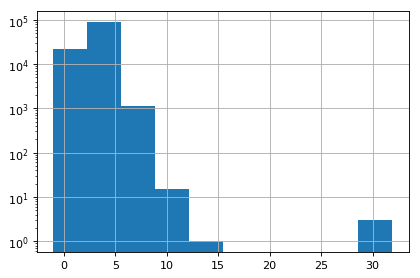

In [47]:
plt.close('all')
# fig, ax = plt.subplots(1,1)
h = flight_data_df.bg_x_y_mean_gz.hist()
h.set_yscale('log')
plt.show()

In [48]:
# current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

# select_clause_str, joined_tables_list = \
#     query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
# join_clauses_str = \
#     query_functions.get_query_clauses__join(joined_tables_list)
# where_clauses_str = ' AND config_info_id=2'
    
# events_selection_query = query_functions.get_events_selection_query_plain(
#     source_data_type_num=1,
#     select_additional=select_clause_str, join_additional=join_clauses_str,
#     where_additional=where_clauses_str,
#     order_by='{data_table_name}.event_id', limit=350000, offset=0,
#     base_select='',
#     data_table_name_overwrite=events_data_table_name)

# flight_data_2_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

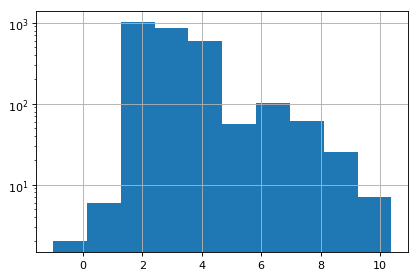

In [49]:
# plt.close('all')
# # fig, ax = plt.subplots(1,1)
# h = flight_data_2_df.bg_x_y_mean_gz.hist()
# h.set_yscale('log')
# plt.show()